<a href="https://colab.research.google.com/github/erfanbyt/pytorch/blob/main/Training_DNN_on_a_GPU_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor  # converting images to tensors
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader  # used to create batches of data and random sampling
from torch.utils.data import random_split

In [2]:
# downloading the dataset
dataset = MNIST(root='/data', 
                download=True,
                transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [3]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

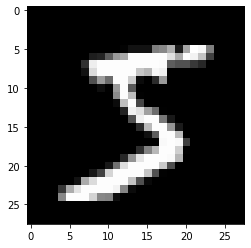

In [4]:
plt.imshow(img[0], cmap='gray')

In [5]:
# splitting the dataset
def split_indices(n, val_pct):
  # size of the validation set
  n_val = int(n * val_pct)
  # creating random permutation
  idxs = np.random.permutation(n)
  # picking the training set and the validaton set
  return idxs[n_val:], idxs[:n_val]

In [6]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 100

# training data
train_sampler = SubsetRandomSampler(train_indices)  # creates shuffled samples from training indices
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)  # this arg. used to select the data from the dataset based on the indices in the sampler


# validation data
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                      batch_size,
                      sampler=valid_sampler)


In [8]:
# creating the model
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class MNISTModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size) -> None:
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # flatten input
    xb = xb.view(xb.shape[0], -1)
    # xb = xb.reshape(xb.shape[0], -1)
    
    # first layer
    out = self.linear1(xb)
    # applying relu
    out = F.relu(out)
    # getting predictions
    out = self.linear2(out)

    return out



In [10]:
input_size = 28 * 28
num_classes = 10

model = MNISTModel(in_size=input_size, hidden_size=32, out_size=num_classes)

In [11]:
# getting parameters in the model
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels  in train_dl:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('loss: {:.4f}'.format(loss))
  break

loss: 2.3289


In [13]:
# using GPU
torch.cuda.is_available()

True

In [14]:
# used to select the device
def get_default_device():
  """pick GPU is available"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
# used to tranfer the model to the chosen device
def to_device(data, device):
  """move tensors to the chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [17]:
# shifting the data to GPU
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)  # if commnet this line, CPU will be printed
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cuda:0


**NOTE:** It is not wise to shift all you data now to GPU. Shift it to GPU rigth before training your model, otherwise memory in GPU will be used!


"return" sends a specified value back to its caller whereas "Yield" can produce a sequence of values. We should use yield when we want to iterate over a sequence, but don't want to store the entire sequence in memory. Yield are used in Python generators.

In [18]:
class DeviceDataLoader():
  """Warp a dataloader to move data to a device"""

  def __init__(self, dl, device) -> None:
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yields a batch of data afer moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """number of the batches"""
    return len(self.dl)

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [20]:
for xb, yb in train_dl:
  print("xb.device:", xb.device)
  print('yb:',yb)
  break

xb.device: cuda:0
yb: tensor([2, 3, 1, 6, 8, 8, 0, 2, 6, 9, 6, 3, 0, 2, 6, 5, 2, 6, 0, 0, 6, 6, 3, 1,
        4, 2, 6, 6, 6, 5, 2, 7, 0, 6, 7, 8, 4, 5, 4, 7, 2, 1, 8, 5, 1, 7, 7, 5,
        5, 9, 7, 4, 6, 5, 7, 0, 8, 0, 6, 9, 1, 1, 3, 1, 8, 6, 0, 0, 7, 6, 4, 6,
        8, 9, 4, 6, 0, 8, 1, 2, 0, 0, 7, 5, 0, 1, 7, 3, 5, 5, 4, 4, 3, 0, 1, 2,
        7, 0, 1, 1], device='cuda:0')


### train the model

In [21]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
  """
    Opt is optional and it will be only used for training, not for the validation
  """
  # calculate the loss
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt is not None:
    # compute the gradients 
    loss.backward()
    # update the parameters
    opt.step()
    # reset the gradients
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    # compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

In [22]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [23]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    # pass each batch through the model
    results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]

    # seperate losses, counts, and metrics
    losses, nums, metrics = zip(*results)

    # total size of the dataset
    total = np.sum(nums)

    # Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses, nums)) / total
    avg_metric = None
    if metric is not None:
      avg_metric = np.sum(np.multiply(metrics, nums)) / total

  return avg_loss, total, avg_metric

In [24]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):

  losses, metrics = [], []
  for epoch in range(epochs):
    # training 
    for xb, yb in train_dl:
      loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

    # evaluation
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    losses.append(val_loss)
    metrics.append(val_metric)

    # print progress
    if metric is None:
      print('Epoch [{}/{}], loss: {:.4f}'.
            format(epoch+1, epochs, val_loss))
    else:
      print('Epoch [{}/{}], loss: {:.4f}, {}: {:.4f}'
      .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

  return losses, metrics

  

    

  

In [25]:
model = MNISTModel(in_size=input_size, hidden_size=32, out_size=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
to_device(model, device)

MNISTModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print(val_loss, total, val_acc)

2.308630037307739 12000 0.06125


In [28]:
losses, metrics = fit(10, model, loss_fn=F.cross_entropy, opt=optimizer, train_dl=train_dl, valid_dl=valid_dl, metric=accuracy)

Epoch [1/10], loss: 0.2561, accuracy: 0.9266
Epoch [2/10], loss: 0.1874, accuracy: 0.9459
Epoch [3/10], loss: 0.1635, accuracy: 0.9538
Epoch [4/10], loss: 0.1587, accuracy: 0.9534
Epoch [5/10], loss: 0.1521, accuracy: 0.9553
Epoch [6/10], loss: 0.1416, accuracy: 0.9604
Epoch [7/10], loss: 0.1504, accuracy: 0.9564
Epoch [8/10], loss: 0.1705, accuracy: 0.9523
Epoch [9/10], loss: 0.1472, accuracy: 0.9581
Epoch [10/10], loss: 0.1728, accuracy: 0.9527


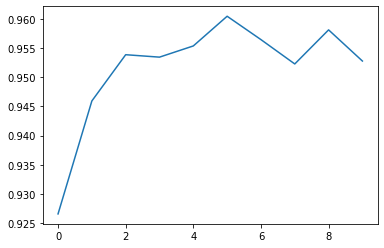

In [29]:
plt.plot(metrics)